# Inter-rater agreement Kappas
a.k.a. inter-rater reliability or concordance

> In statistics, inter-rater reliability, inter-rater agreement, or concordance is the degree of agreement among raters. It gives a score of how much homogeneity, or consensus, there is in the ratings given by judges.

The Kappas covered here are most appropriate for **"nominal"** data. The natural ordering in the data (if any exists) is ignored by these methods. If you're going to use these metrics make sure you're aware of the [limitations](https://www.wikiwand.com/en/Cohen%27s_kappa#/Limitations).

### Cohen's Kappa

\begin{equation*}
\kappa =  1 - \frac{1 - p_o}{1 - p_e}
\end{equation*}

There's two parts to this:
1. Calculate observed agreement
2. Calculate agreement by chance

Let's say we're dealing with "yes" and "no" answers and 2 raters. Here are the ratings:

In [2]:
rater1 = ['yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes']
rater2 = ['yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']

Turning these ratings into a confusion matrix:

|           |Rater 2 yes|Rater 2 no|
|-----------|-----------|----------|
|Rater 1 yes|6          |1         |
|Rater 2 no |1          |1         |

```
Observed agreement = (6 + 1) / 10 = 0.7
Chance agreement   = probability of randomly saying yes (P_yes) + probability of randomly saying no (P_no)
P_yes              = (6 + 1) / 10 * (6 + 1) / 10 = 0.49
P_no               = (1 + 1) / 10 * (1 + 1) / 10 = 0.04
Chance agreement   = 0.49 + 0.04 = 0.53
```

Since the observed agreement is larger than chance agreement we'll get a positive Kappa.

```
kappa = 1 - (1 - 0.7) / (1 - 0.53) = 0.36
```

Or just use `sklearn`'s implementation

In [7]:
from sklearn.metrics import cohen_kappa_score

In [8]:
cohen_kappa_score(rater1, rater2)

0.35714285714285721

#### Interpretation of Kappa
<img src="https://i.stack.imgur.com/kYNd6.png">

### Different cases

#### Less than chance agreement

In [26]:
rater1 = ['no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no']
rater2 = ['yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes']
cohen_kappa_score(rater1, rater2)

-0.21212121212121215

#### If all the ratings are the same and opposite
This case reliably produces a `kappa` of 0

In [33]:
rater1 = ['yes'] * 10
rater2 = ['no'] * 10
cohen_kappa_score(rater1, rater2)

0.0

#### Random ratings
For random ratings `Kappa` follows a normal distribution with a mean of about zero.

As the number of ratings increases there's less variability in the value of Kappa in the distribution.

In [ ]:
%matplotlib inline

10 random ratings for each rater (random sample of 1,000 inter-rater Kappa calculations)


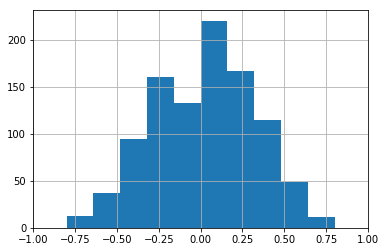



100 random ratings for each rater (random sample of 1,000 inter-rater Kappa calculations)


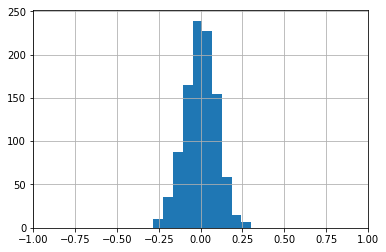



1000 random ratings for each rater (random sample of 1,000 inter-rater Kappa calculations)


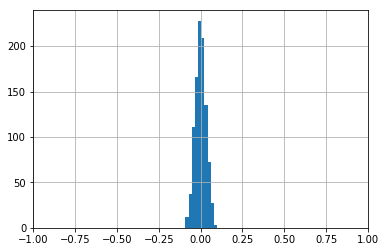

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(0)


for i in [10, 100, 1000]:
    print('{} random ratings for each rater (random sample of 1,000 inter-rater Kappa calculations)'.format(i))
    kappas = [cohen_kappa_score(np.random.choice(['yes', 'no'], i),
                       np.random.choice(['yes', 'no'], i)) for _ in range(1000)]
    pd.Series(kappas).hist();
    plt.xlim([-1, 1])
    plt.show();
    print('\n')

You can find more details [here](https://www.wikiwand.com/en/Cohen%27s_kappa)

**Note that Cohen's Kappa only applied to 2 raters rating the exact same items.**

### Fleiss
Extends Cohen's Kappa to more than 2 raters.

Interpretation
> It can be interpreted as expressing the extent to which the observed amount of agreement among raters exceeds what would be expected if all raters made their ratings completely randomly.

The raters can rate different items whereas for Cohen's they need to rate the exact same items
> Fleiss' kappa specifically allows that although there are a fixed number of raters (e.g., three), different items may be rated by different individuals

\begin{equation*}
\kappa =  \frac{\bar p - \bar p_e}{1-\bar p_e}
\end{equation*}

For example let's say we have 10 raters, each doing a "yes" or "no" rating on 5 items:

n_ij | yes | no | P_i
--- | --- | --- | ---
1 | 10 | 0 | 1
2 | 8 | 2 | 0.64
3 | 9 | 1 | 0.8
4 | 0 | 10 | 1
5 | 7 | 3 | 0.53
**Total** | **34** | **16** | 
p_j | 0.68 | 0.32 |

For example the first row (P_1):
```
P_1 = (10 ** 2 + 0 ** 2 - 10) / (10 * 9) = 1
```

And the first columns (p_1):
```
p_1 = 34 / (5 * 10) = 0.68
```

Go through the worked example [here](https://www.wikiwand.com/en/Fleiss'_kappa#/Worked_example) if this is not clear.

Now you can calculate Kappa:
```
P_bar = (1 / 5) * (1 + 0.64 + 0.8 + 1 + 0.53) = 0.794
P_bar_e = 0.68 ** 2 + 0.32 ** 2 = 0.5648
```

At this point we have everything we need and `kappa` is calculated just as we calculated Cohen's:
```
kappa = (0.794 - 0.5648) / (1 - 0.5648) = 0.53
```

In [115]:
# Adapted from https://gist.github.com/ShinNoNoir/4749548
def fleiss_kappa(ratings, n):
    '''
    Computes the Fleiss' kappa measure for assessing the reliability of 
    agreement between a fixed number n of raters when assigning categorical
    ratings to a number of items.
    
    Args:
        ratings: a list of (item, category)-ratings
        n: number of raters
        k: number of categories
    Returns:
        the Fleiss' kappa score
    
    See also:
        http://en.wikipedia.org/wiki/Fleiss'_kappa
    '''
    items = set()
    categories = set()
    n_ij = {}
    
    for i, c in ratings:
        items.add(i)
        categories.add(c)
        n_ij[(i,c)] = n_ij.get((i,c), 0) + 1
    
    N = len(items)
    
    p_j = dict(((c, sum(n_ij.get((i, c), 0) for i in items) / (1.0 * n * N)) for c in categories))
    P_i = dict(((i, (sum(n_ij.get((i, c), 0) ** 2 for c in categories) - n) / (n * (n - 1.0))) for i in items))

    P_bar = sum(P_i.values()) / (1.0 * N)
    P_e_bar = sum(value ** 2 for value in p_j.values())
    
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    
    return kappa

In [ ]:
ratings = [(1, 'yes')] * 10 + [(1, 'no')] * 0  + \
[(2, 'yes')] * 8  + [(2, 'no')] * 2  + \
[(3, 'yes')] * 9  + [(3, 'no')] * 1  + \
[(4, 'yes')] * 0  + [(4, 'no')] * 10 + \
[(5, 'yes')] * 7  + [(5, 'no')] * 3

In [117]:
fleiss_kappa(ratings, 10)

0.5302287581699346

References
- https://www.wikiwand.com/en/Inter-rater_reliability
- https://www.wikiwand.com/en/Fleiss%27_kappa